In [1]:
import os
from pathlib import Path
import shutil
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
import torchvision.utils as vutils
from tqdm import tqdm
from pytorch_fid.fid_score import calculate_fid_given_paths

from models import Generator_28
from utils import show, show_tensor_images

device = 'cuda'
num_avail_cpus = len(os.sched_getaffinity(0))


## MNIST data to .png

In [ ]:
# mnist_train = datasets.MNIST(
#     root='../data',
#     train=True,
#     download=True,
#     transform=ToTensor()
# )
# mnist_test = datasets.MNIST(
#     root='../data',
#     train=False,
#     download=True,
#     transform=ToTensor()
# )

# mnist_train_imgs = mnist_train.data[:, None, :, :]
# mnist_train_imgs = mnist_train_imgs / 255

# mnist_test_imgs = mnist_test.data[:, None, :, :]
# mnist_test_imgs = mnist_test_imgs / 255

# for i in tqdm(range(len(mnist_train_imgs))):
#     vutils.save_image(mnist_train_imgs[i], f'/d/alecoz/projects/data/MNIST/png/train/{i}.png')

# for i in tqdm(range(len(mnist_test_imgs))):
#     vutils.save_image(mnist_test_imgs[i], f'/d/alecoz/projects/data/MNIST/png/test/{i}.png')

## Load Generator

In [2]:
# fname = './models/DCGAN_corrupted_MNIST_weights_20211208_1838.pth'
# fname = './models/DCGAN_MNIST_weights_20211208_1819.pth' # FID 14.15
fname = './models/DCGAN_conditional_MNIST_weights_20211208_1741.pth' # FID 9.02

conditional = True if 'conditional' in fname else False

z_dim = 64
n_classes = 10 if conditional else 0
generator_input_dim = z_dim + n_classes

gen = Generator_28(generator_input_dim).to(device)
gen.load_state_dict(torch.load(fname))
gen.eval()

Generator_28(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(74, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

## Generate and save images

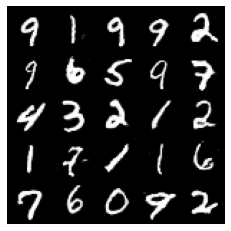

100%|██████████| 10000/10000 [00:26<00:00, 380.15it/s]


In [3]:
nb_images_to_generate = 10000
batch_size = nb_images_to_generate
noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
label = torch.randint(0, 10, (batch_size, ))

if conditional:
    one_hot_labels = nn.functional.one_hot(label.to(device), n_classes)[:,:,None,None]
    noise = torch.cat((noise.float(), one_hot_labels.float()), dim=1)
with torch.no_grad():
    fake = gen(noise).detach().cpu()

show_tensor_images(fake) # show a few images

Path('/d/alecoz/projects/data/.temp').mkdir() # create directory
for i in tqdm(range(len(fake))):
    vutils.save_image(fake[i], f'/d/alecoz/projects/data/.temp/{i}.png')

## Compute FID
Baseline (FID of MNIST train vs MNIST test): 1.031

In [4]:
fid = calculate_fid_given_paths(
    paths=['/d/alecoz/projects/data/MNIST/png/train', '/d/alecoz/projects/data/.temp'], 
    batch_size=50,
    device='cuda',
    dims=2048,
    num_workers=min(num_avail_cpus, 8))
print('FID: {:.2f}'.format(fid))

shutil.rmtree('/d/alecoz/projects/data/.temp') # remove temporary directory


100%|██████████| 200/200 [00:14<00:00, 14.03it/s]


FID: 9.02
